# Integrating multiple scRNA-seq data

This tutorial shows loading, preprocessing, VIPCCA integration and visualization of 293T and Jurkat cells in three different batches (Mixed Cell Lines).


### Importing scbean package
Here, we'll import scbean along with other popular packages.

In [1]:
import scbean.model.vipcca as vip
import scbean.tools.utils as tl
import scbean.tools.plotting as pl

import matplotlib
import scanpy as sc
matplotlib.use('TkAgg')

# Command for Jupyter notebooks only
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

Using TensorFlow backend.


### Loading data
This tutorial uses Mixed Cell Line datasets from [10xgenomics](https://www.10xgenomics.com/cn/) with non-overlapping populations from three batches, two of which contain 293t (2885 cells) and jurkat (3258 cells) cells respectively, and the third batch contains a 1:1 mixture of 293t and jurkat cells (3388 cells).


- Read from 10x mtx file\
The file in 10x mtx format can be downloaded [here](https://support.10xgenomics.com/single-cell-gene-expression/datasets/). Set the fmt parameter of pp.read_sc_data() function to '10x_mtx' to read the data downloaded from 10XGenomics. If the file downloaded from 10XGenomics is in h5 format, the dataset can be loaded by setting the fmt parameter to '10x_h5'.

In [2]:
base_path = "/Users/zhongyuanke/data/vipcca/mixed_cell_lines/"
file1 = base_path+"293t/hg19/"
file2 = base_path+"jurkat/hg19/"
file3 = base_path+"mixed/hg19/"

adata_b1 = tl.read_sc_data(file1, fmt='10x_mtx', batch_name="293t")
adata_b2 = tl.read_sc_data(file2, fmt='10x_mtx', batch_name="jurkat")
adata_b3 = tl.read_sc_data(file3, fmt='10x_mtx', batch_name="mixed")

- Read from h5ad file\
The h5ad file we generated that containing the cell type can be downloaded [here](http://141.211.10.196/result/test/papers/vipcca/data.tar.gz). Here, we load the three datasets separately.

In [3]:
base_path = "/Users/zhongyuanke/data/vipcca/mixed_cell_lines/"

adata_b1 = tl.read_sc_data(base_path+"293t.h5ad", batch_name="293t")
adata_b2 = tl.read_sc_data(base_path+"jurkat.h5ad", batch_name="jurkat")
adata_b3 = tl.read_sc_data(base_path+"mixed.h5ad", batch_name="mixed")

Each dataset is loading into an AnnData object.

In [4]:
adata_b3

AnnData object with n_obs × n_vars = 3388 × 32738
    obs: '_batch', 'celltype'
    var: 'gene_ids'

### Data preprocessing
Here, we filter and normalize each data separately and concatenate them into one AnnData object. For more details, please check the preprocessing API.

In [5]:
adata_all = tl.preprocessing([adata_b1, adata_b2, adata_b3], index_unique="-")

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


### VIPCCA Integration

In [6]:
# Command for Jupyter notebooks only
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# construct a vipcca object
handle = vip.VIPCCA(
    adata_all=adata_all,
    res_path='/Users/zhongyuanke/data/vipcca/mixed_cell_lines/tutorials/',
    mode='CVAE',
    split_by="_batch",
    epochs=20,
    lambda_regulizer=5,
    batch_input_size=128,
    batch_input_size2=16
)
# do integration and return an AnnData object
adata_integrate = handle.fit_integrate()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 2000)         0                                            
__________________________________________________________________________________________________
batch_input1 (InputLayer)       (None, 128)          0                                            
__________________________________________________________________________________________________
encoder_mlp (Model)             [(None, 16), (None,  318368      encoder_input[0][0]              
                                                                 batch_input1[0][0]               
__________________________________________________________________________________________________
batch_input

... storing '_batch' as categorical
... storing 'celltype' as categorical


In [7]:
adata_integrate

AnnData object with n_obs × n_vars = 9530 × 2000
    obs: '_batch', 'celltype', 'n_genes', 'percent_mito', 'n_counts', 'size_factor', 'batch'
    var: 'gene_ids', 'n_cells-0-0', 'highly_variable-0-0', 'means-0-0', 'dispersions-0-0', 'dispersions_norm-0-0', 'n_cells-1-0', 'highly_variable-1-0', 'means-1-0', 'dispersions-1-0', 'dispersions_norm-1-0', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_vipcca'

1.The meta.data of each cell has been saved in adata.obs

2.The embedding representation from vipcca of each cell have been saved in adata.obsm('X_vipcca')

### Loading result
- **Loading result from saved model.h5 file through vipcca**:
The model.h5 file of the trained result can be downloaded [here](http://141.211.10.196/result/test/papers/vipcca/results/mixed_cell_lines/model.h5)

In [8]:
model_path = 'model.h5'
handle = vip.VIPCCA(
    adata_all=adata_all,
    res_path='/Users/zhongyuanke/data/vipcca/mixed_cell_lines/tutorials/',
    mode='CVAE',
    split_by="_batch",
    epochs=20,
    lambda_regulizer=5,
    batch_input_size=128,
    batch_input_size2=16,
    model_file=model_path
)
adata_integrate = handle.fit_integrate()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 2000)         0                                            
__________________________________________________________________________________________________
batch_input1 (InputLayer)       (None, 128)          0                                            
__________________________________________________________________________________________________
encoder_mlp (Model)             [(None, 16), (None,  318368      encoder_input[0][0]              
                                                                 batch_input1[0][0]               
__________________________________________________________________________________________________
batch_input2 (InputLayer)       (None, 16)           0                                      

... storing '_batch' as categorical
... storing 'celltype' as categorical



- **Loading result from h5ad file**:
The output.h5ad file of the trained result can be downloaded [here](http://141.211.10.196/result/test/papers/vipcca/results/mixed_cell_lines/output.h5ad)

In [9]:
integrate_path = '/Users/zhongyuanke/data/vipcca/mixed_cell_lines/tutorials/output.h5ad'
adata_integrate = sc.read_h5ad(integrate_path)

### UMAP Visualization
We use UMAP to reduce the embedding feature output by vipcca in 2 dimensions.

In [8]:
sc.pp.neighbors(adata_integrate, use_rep='X_vipcca')
sc.tl.umap(adata_integrate)

Visualization of UMAP result.

... storing '_batch' as categorical
... storing 'celltype' as categorical


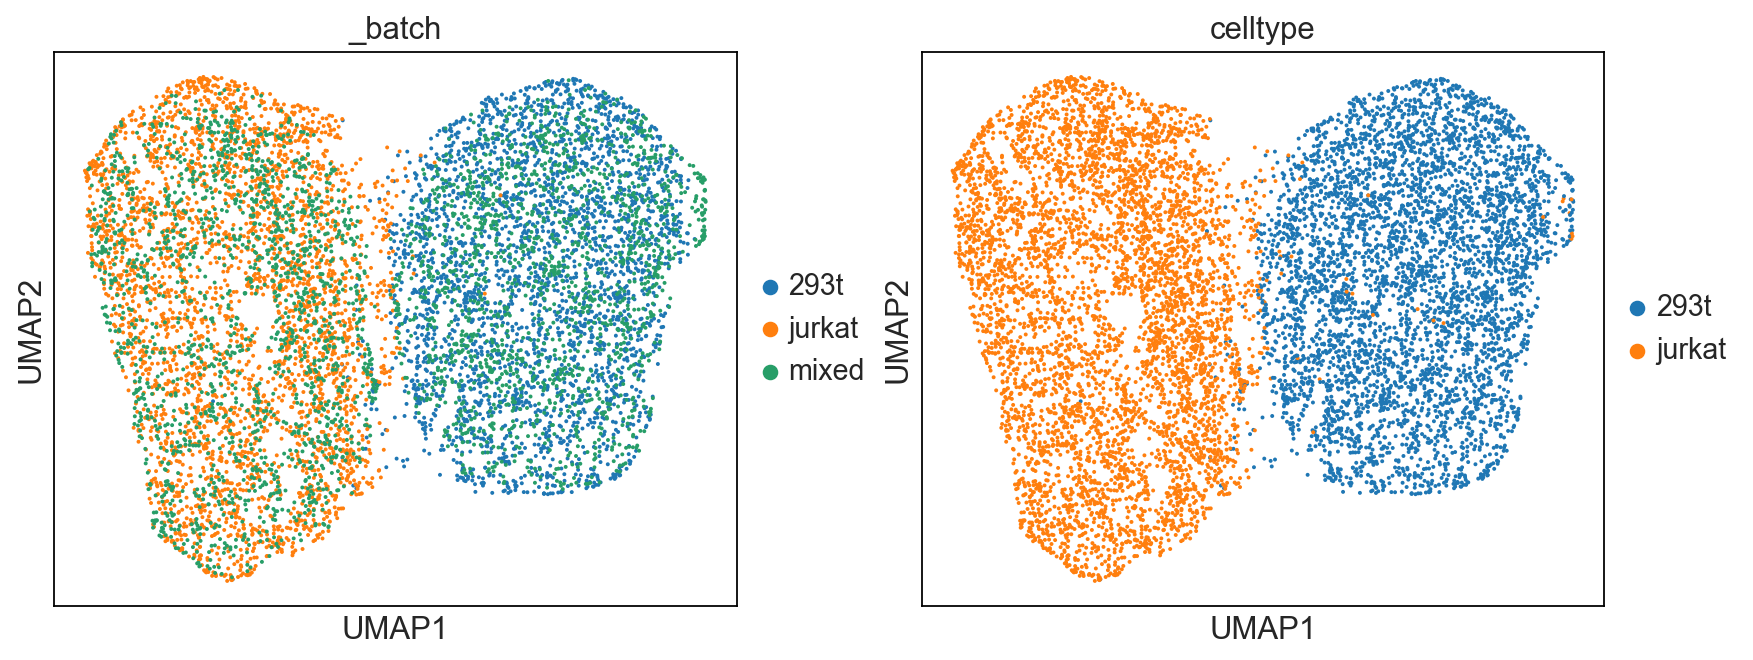

In [9]:
sc.set_figure_params(figsize=[5.5,4.5])
sc.pl.umap(adata_integrate, color=['_batch','celltype'], use_raw=False, show=True,)

### Plot correlation 
This function is only applicable to AnnData generated by fit_integrate() function training. Randomly select 2000 locations in the gene expression matrix. The x-axis represents the expression value of the original data at these locations, and the y-axis represents the expression value of the data after vipcca integration at the same location. 

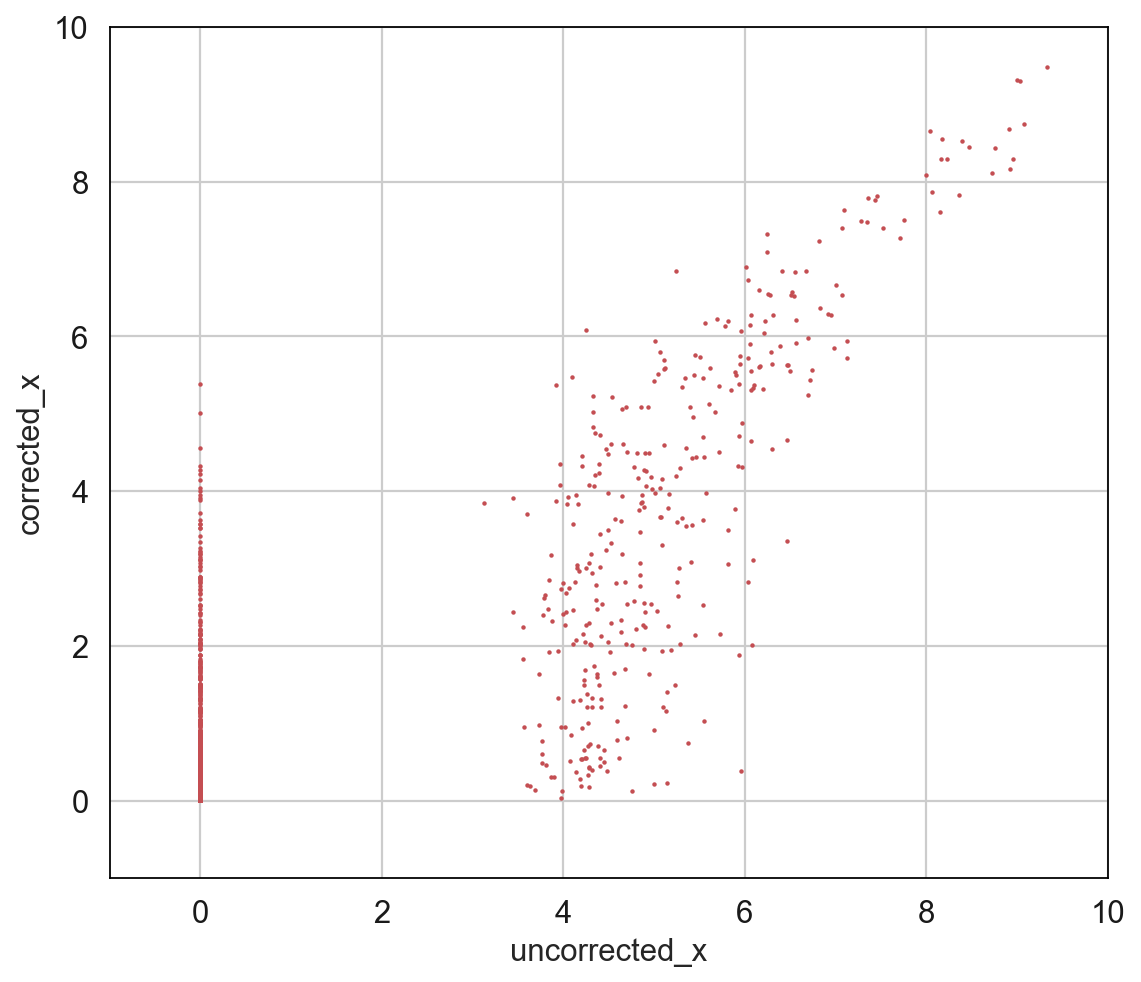

In [10]:
pl.plotCorrelation(adata_integrate.raw.X, adata_integrate.X, save=False, rnum=2000, lim=10)